In [1]:
import csv
import numpy as np
from scipy import interpolate
import scipy.ndimage as ndimage

import cmocean as cmo
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import netCDF4
import pandas as pd
import datetime as dt

from mpl_toolkits.basemap import Basemap

from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Oahu Grid 

In [ ]:
gridxi = np.load("data/gridxi.dat")
gridyi = np.load("data/gridyi.dat")
gridzi = np.load("data/gridzi.dat")

## Loading SWAN wave model

We use the following dataset from the **PacIOOS** (_Pacific Istands Ocean Observing System_): 
- [link to the dataset](http://oos.soest.hawaii.edu/thredds/dodsC/hioos/model/wav/swan/oahu/SWAN_Oahu_Regional_Wave_Model_best.ncd.html)


In [ ]:
# Dataset URL
url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/model/wav/swan/oahu/SWAN_Oahu_Regional_Wave_Model_best.ncd'

# Load it via OPeNDAP
nc = netCDF4.Dataset(url)

In [ ]:
year = 2010
for month in range(1,13):
    for day in range(1,27,7):
        # Desired time for snapshot
        start = dt.datetime(year,month,day,12,0,0)

        # Get desired time step  
        time_var = nc.variables['time']
        # The next line needs to be uncommented  
        itime = netCDF4.date2index(start,time_var,select='nearest') 

        print 'Time ID: ',itime, ' -- Start time of extracted dataset: ',start
        
        lat = nc.variables['lat'][:]
        lon = nc.variables['lon'][:]
        hgt = nc.variables['shgt'][itime, 0, :, :]
        per = nc.variables['mper'][itime, 0, :, :]
        
        swanlon, swanlat = np.meshgrid(lon, lat)
        
        # Wave height
        RGI_function = RegularGridInterpolator((swanlat[:,0].flatten(),swanlon[0,:].flatten()), hgt)
        # Wave period
        RGI_function1 = RegularGridInterpolator((swanlat[:,0].flatten(),swanlon[0,:].flatten()), per)
        
        hgti = RGI_function((gridyi.flatten(), gridxi.flatten()))
        peri = RGI_function1((gridyi.flatten(), gridxi.flatten()))
        hgti = hgti.reshape((gridyi.shape))
        peri = peri.reshape((gridyi.shape))
        
        rows,cols = np.where(gridzi>=0)
        hgti[rows,cols] = 0.
        peri[rows,cols] = 0.

        hgti = hgti.astype(float)
        peri = peri.astype(float)
        
        mask = np.zeros(hgti.shape)

        rows1,cols1 = np.where(np.isnan(hgti))
        hgti[rows1,cols1] = np.nan
        rows1,cols1 = np.where(np.isnan(peri))
        peri[rows1,cols1] = np.nan
        
        x = np.arange(0, hgti.shape[1])
        y = np.arange(0, hgti.shape[0])

        # Mask invalid values
        hgti = np.ma.masked_invalid(hgti)
        xx, yy = np.meshgrid(x, y)

        # Only the valid values
        x1 = xx[~hgti.mask]
        y1 = yy[~hgti.mask]
        newarr = hgti[~hgti.mask]

        # Perform cubic interpolation
        gridH = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method='cubic')
        gridH = ndimage.gaussian_filter(gridH, sigma=2, order=0)
        gridH[gridH<0]=0.
        
        x = np.arange(0, peri.shape[1])
        y = np.arange(0, peri.shape[0])

        # Mask invalid values
        peri = np.ma.masked_invalid(peri)
        xx, yy = np.meshgrid(x, y)

        # Only the valid values
        x1 = xx[~peri.mask]
        y1 = yy[~peri.mask]
        newarr = peri[~peri.mask]

        # Perform cubic interpolation
        gridT = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method='cubic')
        gridT = ndimage.gaussian_filter(gridT, sigma=2, order=0)
        gridT[gridT<0]=0.
        
        gridUw = 0.2*(gridH/2.)*np.sqrt(9.81/-gridzi)

        # Nullify values above water
        rows,cols = np.where(gridzi>=0)
        gridUw[rows,cols] = 0.
        
        
        gridUw.dump("data/gridUw-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        gridT.dump("data/gridT-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")

In [2]:
# Grid related dataset:
gridxi = np.load("data/gridxi.dat")
gridyi = np.load("data/gridyi.dat")
gridzi = np.load("data/gridzi.dat")

In [3]:
minlat = 21.57
maxlat = 21.63
minlon = 360.-158.22
maxlon = 360.-158.08
print gridxi.min(),gridxi.max()
print gridyi.min(),gridyi.max()
print minlon,maxlon

201.65 202.3994
21.2001 21.7497
201.78 201.92


In [9]:
grid_res = 0.0008
ngridX = np.arange(minlon,maxlon+grid_res,grid_res)
ngridY = np.arange(minlat,maxlat+grid_res,grid_res)
kailuaxi, kailuayi = np.meshgrid(ngridX, ngridY)

In [4]:
# Bathymetry
RGI_function2 = RegularGridInterpolator((gridyi[:,0].flatten(),gridxi[0,:].flatten()), gridzi)

In [17]:
alpha = 0.55
rhos = 2600.
rhow = 1024.
mu = 1.002e-3
grav = 9.81
g = 9.81
vk = 0.4
area = 88*88

# Setting up parameters
S = rhos / rhow
nu = mu / rhow
sqg = grav**(0.5)
Sf = 0.556

In [18]:
def drag_coefficient_siliciclastic(sqg,nu,a1,a2,a3,d): 
    return np.power(a1*nu/(sqg*np.power(d,1.5))+a2,a3)

def settling_velocity_siliciclastic(g,S,CD,Sf,d):
    return np.sqrt(4/3*(S-1.)*g/CD * np.power(Sf,2./3.) * d)

def drag_coefficient_calcareous(sqg,nu,a3,a4,a5,a6,a7,a8,d):
    CD1 = np.power(a3*nu/(sqg*np.power(d,1.5))+a4,a5)
    CD2 = np.power(a6*nu/(sqg*np.power(d,1.5))+a7,a8)
    return CD1+CD2

def settling_velocity_calcareous(g,S,alpha,CD,Sf,d):
    return np.sqrt(alpha*4/3*(S-1.)*g/CD * np.power(Sf,2./3.) * d)

In [234]:
grainsize = 0.43
grainsize = 0.13
grainsize = 1.07

In [239]:
year = 2015
for month in range(1,13):
    for day in range(1,27,7):
        gridUw = np.load("data/gridUw-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        gridT = np.load("data/gridT-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        # Wave period
        RGI_function1 = RegularGridInterpolator((gridyi[:,0].flatten(),gridxi[0,:].flatten()), gridT)
        # Bottom velocity
        RGI_function3 = RegularGridInterpolator((gridyi[:,0].flatten(),gridxi[0,:].flatten()), gridUw)
        # Interpolate on zone
        kailuaZ = RGI_function2((kailuayi.flatten(), kailuaxi.flatten()))
        kailuaT = RGI_function1((kailuayi.flatten(), kailuaxi.flatten()))
        kailuaUw = RGI_function3((kailuayi.flatten(), kailuaxi.flatten()))
        kailuaZ = kailuaZ.reshape((kailuayi.shape))
        kailuaT = kailuaT.reshape((kailuayi.shape))
        kailuaUw = kailuaUw.reshape((kailuayi.shape))
        r,c = np.where(kailuaZ>0)
        kailuaT[r,c] = 0.
        kailuaUw[r,c] = 0.
        # Grain size
        kailuaGZ = np.zeros(kailuaT.shape)
        kailuaGZ.fill(grainsize)
        # Parameters
        rhow = 1024.
        # Wave-orbital semiexcursion
        Ab = kailuaUw * kailuaT
        # Bed roughness
        kb = np.pi * kailuaGZ*0.001 / 12.
        # Wave friction factor
        ids = np.where(np.logical_and(kb>0,Ab>0))
        fw = np.zeros(kb.shape)
        fw[ids] = 1.39 * np.power(Ab[ids]/kb[ids],-0.52)
        # Shear stress
        shear = 0.5 * rhow * fw * kailuaUw*kailuaUw
        shear[r,c] = 0.
        a1 = 96.45 - 74.74*Sf**(-0.113)
        a2 = 1.129 - 0.435*Sf**(1.7)
        a3 = 2.023
        # Compute CD
        CDsil = drag_coefficient_siliciclastic(sqg,nu,a1,a2,a3,kailuaGZ*0.001)  
        # Compute fall vekocity ws
        wssil = settling_velocity_siliciclastic(g,S,CDsil,Sf,kailuaGZ*0.001)
        a3 = 9.5
        a4 = 0.76
        a5 = 2.92
        a6 = 20.47
        a7 = 1.02
        a8 = -48.15
        # Compute CD
        CDcalc = drag_coefficient_calcareous(sqg,nu,a3,a4,a5,a6,a7,a8,kailuaGZ*0.001)  
        # Compute fall vekocity ws
        wscalc = settling_velocity_calcareous(grav,S,alpha,CDcalc,Sf,kailuaGZ*0.001)
        # For carbonate sands
        rousecalc = wscalc/(vk*shear)
        r,c = np.where(shear<0.0001)
        rousecalc[r,c] = 0.
        kailuaRouseCalc = ndimage.gaussian_filter(rousecalc, sigma=2, order=0)
        kailuaRouseCalc[r,c] = 0.
        # For siliciclastic sands
        rousesil = wssil/(vk*shear)
        r,c = np.where(shear<0.0001)
        rousesil[r,c] = 0.
        kailuaRouseSil = ndimage.gaussian_filter(rousesil, sigma=2, order=0)
        kailuaRouseSil[r,c] = 0.
        # Comparison
        rousil = np.copy(kailuaRouseSil)
        r1,c1 = np.where(np.logical_and(rousil>0,rousil<0.8))
        r2,c2 = np.where(np.logical_and(rousil>=0.8,rousil<1.2))
        r3,c3 = np.where(np.logical_and(rousil>=1.2,rousil<2.5))
        r4,c4 = np.where(rousil>2.5)
        rousil[r1,c1] = 1 # wash load
        rousil[r2,c2] = 2 # susp load (100%)
        rousil[r3,c3] = 3 # susp load (50%)
        rousil[r4,c4] = 4 # bedload
        #
        rouscal = np.copy(kailuaRouseCalc)
        r1,c1 = np.where(np.logical_and(rouscal>0,rouscal<0.8))
        r2,c2 = np.where(np.logical_and(rouscal>=0.8,rouscal<1.2))
        r3,c3 = np.where(np.logical_and(rouscal>=1.2,rouscal<2.5))
        r4,c4 = np.where(rouscal>2.5)
        rouscal[r1,c1] = 1 # wash load
        rouscal[r2,c2] = 2 # susp load (100%)
        rouscal[r3,c3] = 3 # susp load (50%)
        rouscal[r4,c4] = 4 # bedload
        # Total area per model of transport
        r,c = np.where(rouscal==1)
        washcal = len(r)*area
        tot = 0
        tot += len(r)
        r,c = np.where(rouscal==2)
        susp5cal = len(r)*area
        tot += len(r)
        r,c = np.where(rouscal==3)
        susp10cal = len(r)*area
        tot += len(r)
        r,c = np.where(rouscal==4)
        bedcal = len(r)*area
        tot += len(r)
        gl = float(tot*area)
        caperwash = washcal/gl
        capersusp5 = susp5cal/gl
        capersusp10 = susp10cal/gl
        caperbed = bedcal/gl
        r,c = np.where(rousil==1)
        washsil = len(r)*area
        tot = 0
        tot += len(r)
        r,c = np.where(rousil==2)
        susp5sil = len(r)*area
        tot += len(r)
        r,c = np.where(rousil==3)
        susp10sil = len(r)*area
        tot += len(r)
        r,c = np.where(rousil==4)
        bedsil = len(r)*area
        tot += len(r)
        gl = float(tot*area)
        siperwash = washsil/gl
        sipersusp5 = susp5sil/gl
        sipersusp10 = susp10sil/gl
        siperbed = bedsil/gl
        x = np.arange(4)+1
        y = np.zeros(4)
        y1 = np.zeros(4)
        y[0] = siperwash
        y[1] = sipersusp5
        y[2] = sipersusp10
        y[3] = siperbed
        y1[0] = caperwash
        y1[1] = capersusp5
        y1[2] = capersusp10
        y1[3] = caperbed
        # Save data
        x.dump("data/maxXtransMode-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y.dump("data/maxYtransModeSil-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y1.dump("data/maxYtransModeCalc-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")

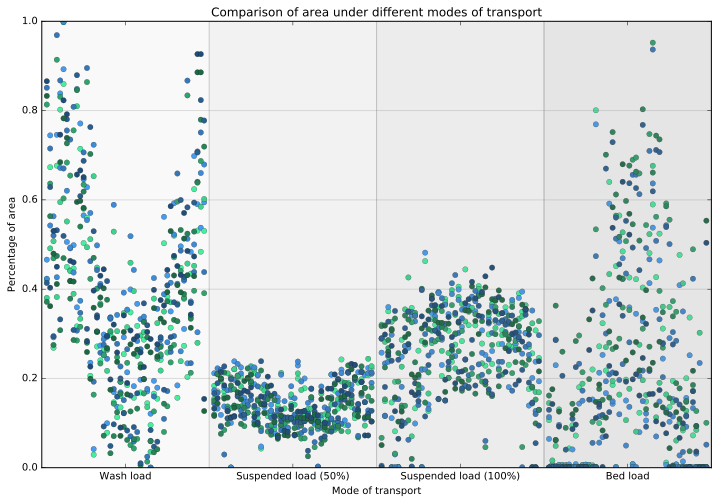

192


In [255]:
fig = plt.figure()
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = (12,8)

p = 0
yr = 2011


#ax.fill_between(x, 0, 1, where=y < -theta, facecolor='red', alpha=0.5, transform=trans)
plt.axvspan(0.5, 1.5, alpha=0.05, color='grey')
plt.axvline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.2, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(1.5, 2.5, alpha=0.1, color='grey')
plt.axvline(2.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.4, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(2.5, 3.5, alpha=0.15, color='grey')
plt.axvline(3.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.6, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(3.5, 4.5, alpha=0.2, color='grey')
plt.axhline(0.8, color='grey', linestyle='-',alpha=0.25)

yr = -1
toty = np.zeros((12*4*4,5))
toty1 = np.zeros((12*4*4,5))
for year in range(2011,2016):
    yr += 1
    if yr == 0:
        sc = '#42f4a1' 
        cc = '#419df4' 
    elif yr == 1:
        sc = '#38d88d' 
        cc = '#398cdb' 
    elif yr == 2:
        sc = '#2ba56c' 
        cc = '#3178bc' 
    elif yr == 3:
        sc = '#218456' 
        cc = '#245c91' 
    elif yr == 4:
        sc = '#176641' 
        cc = '#1a4a77' 
    p = 0
    for month in range(1,13):
        for day in range(1,28,7):
            
            x = np.load("data/minXtransMode-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
            y = np.load("data/minYtransModeSil-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
            y1 = np.load("data/minYtransModeCalc-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
            if yr == 0:
                if p == 0:
                    totx = x-0.5+0.02*p+0.03
                else:
                    totx = np.append(totx,x-0.5+0.02*p+0.03)
            if p == 0:
                tmpy = y
                tmpy1 = y1
            else:
                tmpy = np.append(tmpy,y)
                tmpy1 = np.append(tmpy1,y1)
            
            plt.scatter(x-0.5+0.02*p+0.03, y, s=30, facecolors=sc, edgecolors='k', linewidth='0.2', label='silicilastic sand')
            plt.scatter(x-0.5+0.02*p+0.03, y1, s=30, facecolors=cc, edgecolors='k', linewidth='0.2', label='calcareous sand')
            #plt.legend(loc='upper right')
            p += 1
    toty[:,yr] = tmpy
    toty1[:,yr] = tmpy1

plt.xlim(0.5,4.5)
plt.ylim(0.,1.)
plt.title("Comparison of area under different modes of transport")
plt.xlabel("Mode of transport")
plt.ylabel("Percentage of area")


xl = [1., 2., 3., 4.]
labels = ['Wash load', 'Suspended load (50%)', 'Suspended load (100%)', 'Bed load']
plt.xticks(xl, labels)

plt.show()
#fig.savefig('figs/comprousemaxdia.pdf')

print len(totx)

In [256]:
print len(totx),toty.shape
print toty[0,:]
meany = np.mean(toty,axis=1)
stdy = np.std(toty,axis=1)
meany1 = np.mean(toty1,axis=1)
stdy1 = np.std(toty1,axis=1)

miny = np.min(toty,axis=1)
maxy = np.max(toty,axis=1)

miny1 = np.min(toty1,axis=1)
maxy1 = np.max(toty1,axis=1)

192 (192, 5)
[ 0.42133164  0.38032648  0.81354675  0.37152851  0.83283867]


In [257]:
stackmeany = np.column_stack((totx,meany))
sortmeany=stackmeany[stackmeany[:,0].argsort()]

stackmeany1 = np.column_stack((totx,meany1))
sortmeany1=stackmeany1[stackmeany1[:,0].argsort()]

stackminy = np.column_stack((totx,miny))
sortminy = stackminy[stackminy[:,0].argsort()]

stackminy1 = np.column_stack((totx,miny1))
sortminy1=stackminy1[stackminy1[:,0].argsort()]

stackmaxy = np.column_stack((totx,maxy))
sortmaxy=stackmaxy[stackmaxy[:,0].argsort()]

stackmaxy1 = np.column_stack((totx,maxy1))
sortmaxy1=stackmaxy1[stackmaxy1[:,0].argsort()]

In [258]:

f1 = interp1d(sortmeany[:,0], sortmeany[:,1], kind='cubic')
f2 = interp1d(sortmeany1[:,0], sortmeany1[:,1], kind='cubic')

f1min = interp1d(sortminy[:,0], sortminy[:,1], kind='cubic')
f2min = interp1d(sortminy1[:,0], sortminy1[:,1], kind='cubic')

f1max = interp1d(sortmaxy[:,0], sortmaxy[:,1], kind='cubic')
f2max = interp1d(sortmaxy1[:,0], sortmaxy1[:,1], kind='cubic')

xnew = np.linspace(0.53, 4.47, num=1000, endpoint=True)
ysil = f1(xnew)
ycal = f2(xnew)

yminsil = f1min(xnew)
ymincal = f2min(xnew)

ymaxsil = f1max(xnew)
ymaxcal = f2max(xnew)

#print sortmeany[:,0]

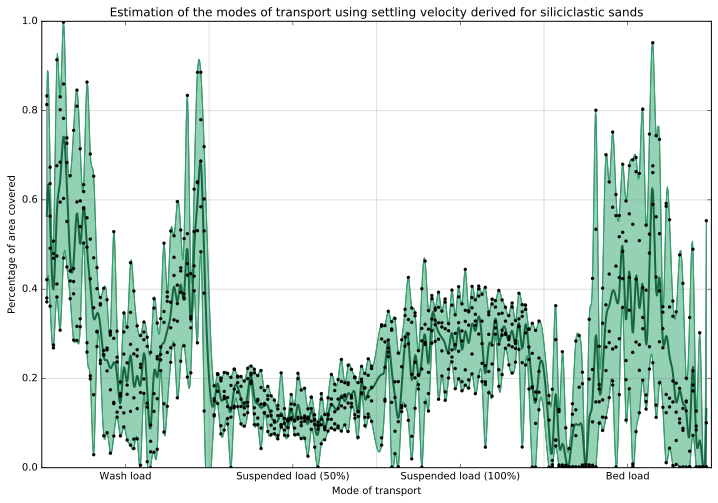

In [259]:
fig = plt.figure()
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = (12,8)

#plt.axvspan(0.5, 1.5, alpha=0.05, color='grey')
plt.axvline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.2, color='grey', linestyle='-',alpha=0.25)
#plt.axvspan(1.5, 2.5, alpha=0.1, color='grey')
plt.axvline(2.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.4, color='grey', linestyle='-',alpha=0.25)
#plt.axvspan(2.5, 3.5, alpha=0.15, color='grey')
plt.axvline(3.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.6, color='grey', linestyle='-',alpha=0.25)
#plt.axvspan(3.5, 4.5, alpha=0.2, color='grey')
plt.axhline(0.8, color='grey', linestyle='-',alpha=0.25)

#419df4
plt.plot(xnew, ysil, color='#176641',linewidth='2',label='silicilastic sand',zorder=2) #, color='#42f4a1', linewidth='2', label='silicilastic sand')
plt.plot(xnew, yminsil, color='#2ba56c',zorder=1)
plt.plot(xnew, ymaxsil, color='#2ba56c',zorder=1)
plt.fill_between(xnew, yminsil, ymaxsil, where=ymaxsil >= yminsil, facecolor='#2ba56c', interpolate=True, alpha=0.5,zorder=1)

yr = -1
for year in range(2011,2016):
    yr += 1
    p = 0
    for month in range(1,13):
        for day in range(1,28,7):
            
            x = np.load("data/minXtransMode-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
            y = np.load("data/minYtransModeSil-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
            plt.scatter(x-0.5+0.02*p+0.03, y, s=10, facecolors='k', edgecolors='k', linewidth='0.2', label='silicilastic sand',zorder=3)
            p += 1

plt.xlim(0.5,4.5)
plt.ylim(0.,1.)
plt.title("Estimation of the modes of transport using settling velocity derived for siliciclastic sands")
plt.xlabel("Mode of transport")
plt.ylabel("Percentage of area covered")

xl = [1., 2., 3., 4.]
labels = ['Wash load', 'Suspended load (50%)', 'Suspended load (100%)', 'Bed load']
plt.xticks(xl, labels)

plt.show()
#fig.savefig('figs/maxsiliciclasticarea.pdf')

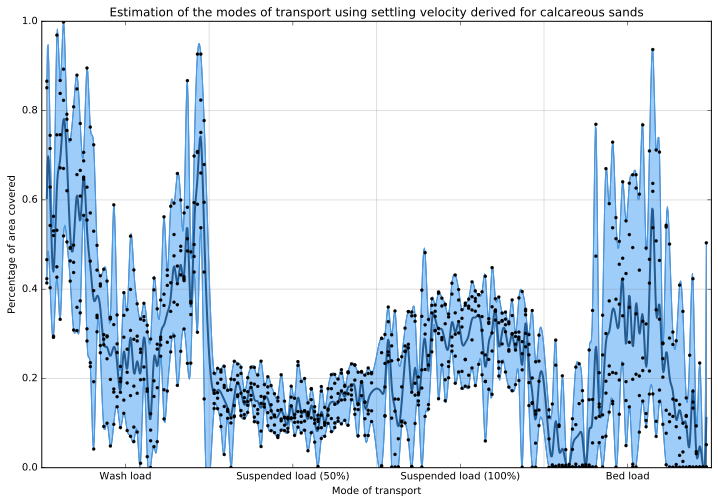

In [260]:
fig = plt.figure()
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = (12,8)

#plt.axvspan(0.5, 1.5, alpha=0.05, color='grey')
plt.axvline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.2, color='grey', linestyle='-',alpha=0.25)
#plt.axvspan(1.5, 2.5, alpha=0.1, color='grey')
plt.axvline(2.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.4, color='grey', linestyle='-',alpha=0.25)
#plt.axvspan(2.5, 3.5, alpha=0.15, color='grey')
plt.axvline(3.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.6, color='grey', linestyle='-',alpha=0.25)
#plt.axvspan(3.5, 4.5, alpha=0.2, color='grey')
plt.axhline(0.8, color='grey', linestyle='-',alpha=0.25)

plt.plot(xnew, ycal, color='#245c91',linewidth='2',label='calcareous sand',zorder=2) #, color='#42f4a1', linewidth='2', label='silicilastic sand')
plt.plot(xnew, ymincal, color='#419df4',zorder=1)
plt.plot(xnew, ymaxcal, color='#419df4',zorder=1)
plt.fill_between(xnew, ymincal, ymaxcal, where=ymaxcal >= ymincal, facecolor='#419df4', interpolate=True, alpha=0.5,zorder=1)

yr = -1
for year in range(2011,2016):
    yr += 1
    p = 0
    for month in range(1,13):
        for day in range(1,28,7):
            
            x = np.load("data/minXtransMode-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
            y = np.load("data/minYtransModeCalc-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
            plt.scatter(x-0.5+0.02*p+0.03, y, s=10, facecolors='k', edgecolors='k', linewidth='0.2', label='silicilastic sand',zorder=3)
            p += 1


#plt.legend(loc='upper left')
#plt.plot(xnew, ycal) #plt.scatter(x-0.5+0.02*p+0.03, y1, s=30, facecolors=cc, edgecolors='k', linewidth='0.2', label='calcareous sand')

plt.xlim(0.5,4.5)
plt.ylim(0.,1.)
plt.title("Estimation of the modes of transport using settling velocity derived for calcareous sands")
plt.xlabel("Mode of transport")
plt.ylabel("Percentage of area covered")

xl = [1., 2., 3., 4.]
labels = ['Wash load', 'Suspended load (50%)', 'Suspended load (100%)', 'Bed load']
plt.xticks(xl, labels)

plt.show()
#fig.savefig('figs/maxcalcareousarea.pdf')

In [246]:
diffmax = ycal/ysil

In [275]:
ycal[ycal<0.0003] = 0.0003
ysil[ysil<0.0003] = 0.0003
diffmin = ycal/ysil

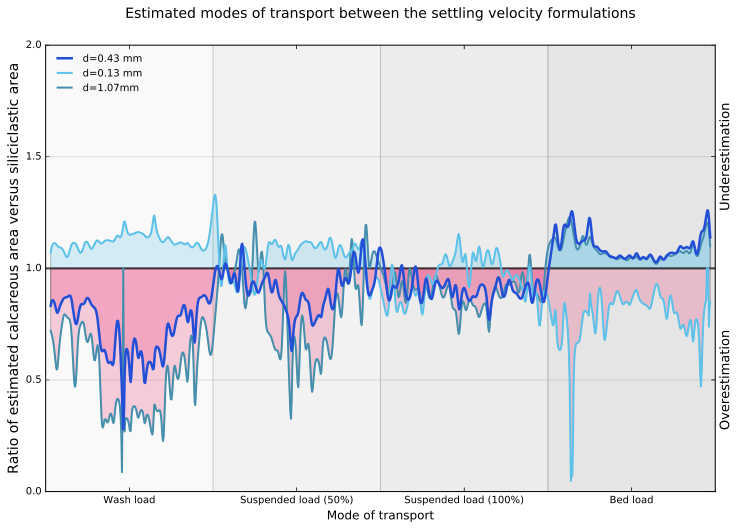

In [324]:
fig = plt.figure()
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = (12,8)

#plt.axhspan(0., 1., alpha=0.1, color='#ed0d0d')
#plt.axhspan(1., 2., alpha=0.1, color='#0e42ed')

plt.axvspan(0.5, 1.5, alpha=0.05, color='grey')
plt.axvline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(0.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(1.5, 2.5, alpha=0.1, color='grey')
plt.axvline(2.5, color='grey', linestyle='-',alpha=0.25)
plt.axhline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(2.5, 3.5, alpha=0.15, color='grey')
plt.axvline(3.5, color='grey', linestyle='-',alpha=0.25)
#plt.axhline(0.6, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(3.5, 4.5, alpha=0.2, color='grey')
#plt.axhline(0.8, color='grey', linestyle='-',alpha=0.25)
plt.axhline(1., color='k', linestyle='-',alpha=0.5,linewidth='2.5')
# plt.axhline(1.2, color='grey', linestyle='-',alpha=0.25)
# plt.axhline(1.4, color='grey', linestyle='-',alpha=0.25)
# plt.axhline(1.6, color='grey', linestyle='-',alpha=0.25)
# plt.axhline(1.8, color='grey', linestyle='-',alpha=0.25)

plt.plot(xnew, diff, color='#224fd6',linewidth='2.5',label='d=0.43 mm',zorder=5)
plt.plot(xnew, diffmin, color='#5dc2ea',linewidth='2',label='d=0.13 mm',zorder=4) 
plt.plot(xnew, diffmax, color='#458fad',linewidth='2',label='d=1.07mm',zorder=3)

center = np.ones(len(xnew))
plt.fill_between(xnew, center, diffmin, where=diffmin >= center, facecolor='#5dc2ea', interpolate=True, alpha=0.25,zorder=2)
plt.fill_between(xnew, center, diffmin, where=diffmin <= center, facecolor='#e83c7b', interpolate=True, alpha=0.25,zorder=2)

plt.fill_between(xnew, center, diffmax, where=diffmax >= center, facecolor='#5dc2ea', interpolate=True, alpha=0.25,zorder=2)
plt.fill_between(xnew, center, diffmax, where=diffmax <= center, facecolor='#e83c7b', interpolate=True, alpha=0.25,zorder=2)

plt.fill_between(xnew, center, diff, where=diff >= center, facecolor='#5dc2ea', interpolate=True, alpha=0.25,zorder=2)
plt.fill_between(xnew, center, diff, where=diff <= center, facecolor='#e83c7b', interpolate=True, alpha=0.25,zorder=2)



ax2 = fig.add_subplot(111, sharex=ax, frameon=False)
ax2.yaxis.tick_right()
ax2.set_xticklabels([])
ax2.yaxis.tick_right()
yl = [0.25,0.75]
labels = ['Overestimation', 'Underestimation']
plt.yticks(yl, labels, rotation='vertical', fontsize = 13)

ax = fig.add_subplot(111)

lg = plt.legend(loc='upper left',prop={'size':10})
lg.draw_frame(False)
plt.xlim(0.5,4.5)
plt.ylim(0.,2)


plt.title("Estimated modes of transport between the settling velocity formulations", fontsize = 14)

ttl = ax.title
ttl.set_position([.5, 1.05])

plt.xlabel("Mode of transport", fontsize = 12)
plt.ylabel("Ratio of estimated calcareous area versus siliciclastic area", fontsize = 14)
xl = [1., 2., 3., 4.]
labels = ['Wash load', 'Suspended load (50%)', 'Suspended load (100%)', 'Bed load']
plt.xticks(xl, labels, fontsize = 10)

plt.show()
fig.savefig('figs/diffarea.pdf')

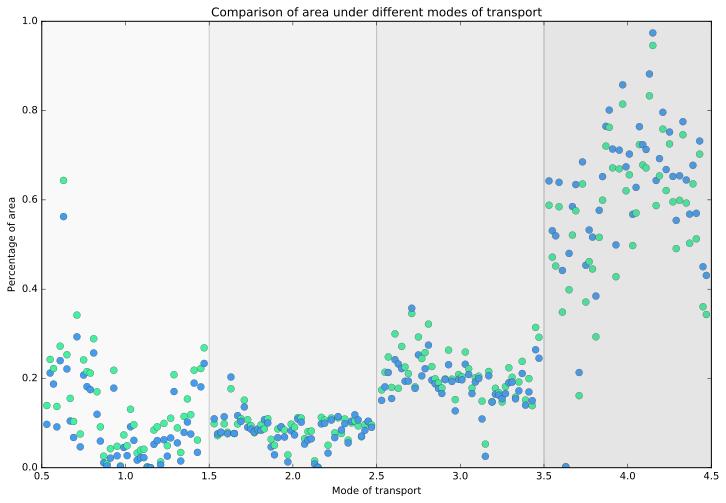

In [277]:
fig = plt.figure()
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = (12,8)

p = 0
year = 2012

#ax.fill_between(x, 0, 1, where=y < -theta, facecolor='red', alpha=0.5, transform=trans)
plt.axvspan(0.5, 1.5, alpha=0.05, color='grey')
plt.axvline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(1.5, 2.5, alpha=0.1, color='grey')
plt.axvline(2.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(2.5, 3.5, alpha=0.15, color='grey')
plt.axvline(3.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(3.5, 4.5, alpha=0.2, color='grey')

silcolor[0] = '#42f4a1'
silcolor[1] = '#35c481'
silcolor[2] = '#2ba56c'
silcolor[3] = '#218456'
silcolor[4] = '#176641'

calcolor[0] = '#419df4'
calcolor[1] = '#398cdb'
calcolor[2] = '#3178bc'
calcolor[3] = '#245c91'
calcolor[4] = '#1a4a77'

for month in range(1,13):
    for day in range(1,28,7):

        x = np.load("data/XtransMode-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y = np.load("data/YtransModeSil-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y1 = np.load("data/YtransModeCalc-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        plt.scatter(x-0.5+0.02*p+0.03, y, s=50, facecolors='#42f4a1', edgecolors='k', linewidth='0.2', label='silicilastic sand')
        plt.scatter(x-0.5+0.02*p+0.03, y1, s=50, facecolors='#419df4', edgecolors='k', linewidth='0.2', label='calcareous sand')
        #plt.legend(loc='upper right')
        p += 1

plt.xlim(0.5,4.5)
plt.ylim(0.,1.)
plt.title("Comparison of area under different modes of transport")
plt.xlabel("Mode of transport")
plt.ylabel("Percentage of area")

plt.show()
fig.savefig('figs/comprouse2012.pdf')

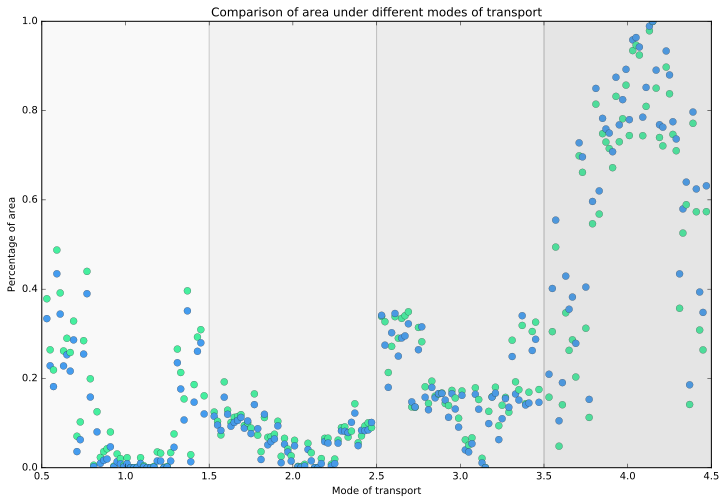

In [87]:
fig = plt.figure()
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = (12,8)

p = 0
year = 2013

#ax.fill_between(x, 0, 1, where=y < -theta, facecolor='red', alpha=0.5, transform=trans)
plt.axvspan(0.5, 1.5, alpha=0.05, color='grey')
plt.axvline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(1.5, 2.5, alpha=0.1, color='grey')
plt.axvline(2.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(2.5, 3.5, alpha=0.15, color='grey')
plt.axvline(3.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(3.5, 4.5, alpha=0.2, color='grey')

for month in range(1,13):
    for day in range(1,28,7):

        x = np.load("data/XtransMode-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y = np.load("data/YtransModeSil-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y1 = np.load("data/YtransModeCalc-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        plt.scatter(x-0.5+0.02*p+0.03, y, s=50, facecolors='#42f4a1', edgecolors='k', linewidth='0.2', label='silicilastic sand')
        plt.scatter(x-0.5+0.02*p+0.03, y1, s=50, facecolors='#419df4', edgecolors='k', linewidth='0.2', label='calcareous sand')
        #plt.legend(loc='upper right')
        p += 1

plt.xlim(0.5,4.5)
plt.ylim(0.,1.)
plt.title("Comparison of area under different modes of transport")
plt.xlabel("Mode of transport")
plt.ylabel("Percentage of area")

plt.show()
fig.savefig('figs/comprouse2013.pdf')

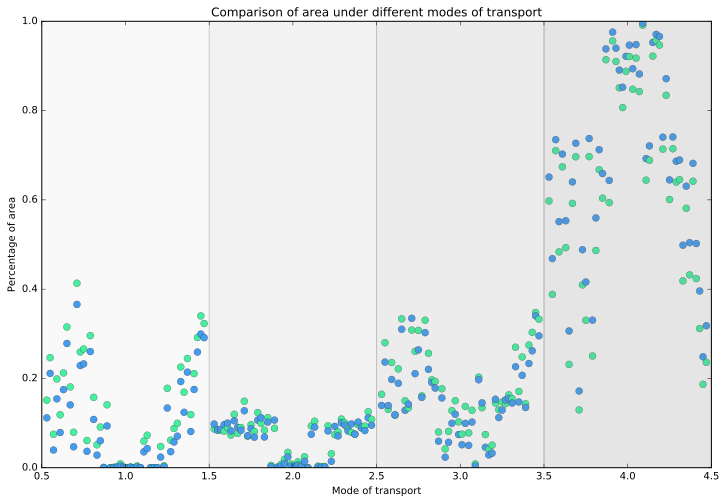

In [88]:
fig = plt.figure()
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = (12,8)

p = 0
year = 2014

#ax.fill_between(x, 0, 1, where=y < -theta, facecolor='red', alpha=0.5, transform=trans)
plt.axvspan(0.5, 1.5, alpha=0.05, color='grey')
plt.axvline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(1.5, 2.5, alpha=0.1, color='grey')
plt.axvline(2.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(2.5, 3.5, alpha=0.15, color='grey')
plt.axvline(3.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(3.5, 4.5, alpha=0.2, color='grey')

for month in range(1,13):
    for day in range(1,28,7):

        x = np.load("data/XtransMode-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y = np.load("data/YtransModeSil-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y1 = np.load("data/YtransModeCalc-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        plt.scatter(x-0.5+0.02*p+0.03, y, s=50, facecolors='#42f4a1', edgecolors='k', linewidth='0.2', label='silicilastic sand')
        plt.scatter(x-0.5+0.02*p+0.03, y1, s=50, facecolors='#419df4', edgecolors='k', linewidth='0.2', label='calcareous sand')
        #plt.legend(loc='upper right')
        p += 1

plt.xlim(0.5,4.5)
plt.ylim(0.,1.)
plt.title("Comparison of area under different modes of transport")
plt.xlabel("Mode of transport")
plt.ylabel("Percentage of area")

plt.show()
fig.savefig('figs/comprouse2014.pdf')

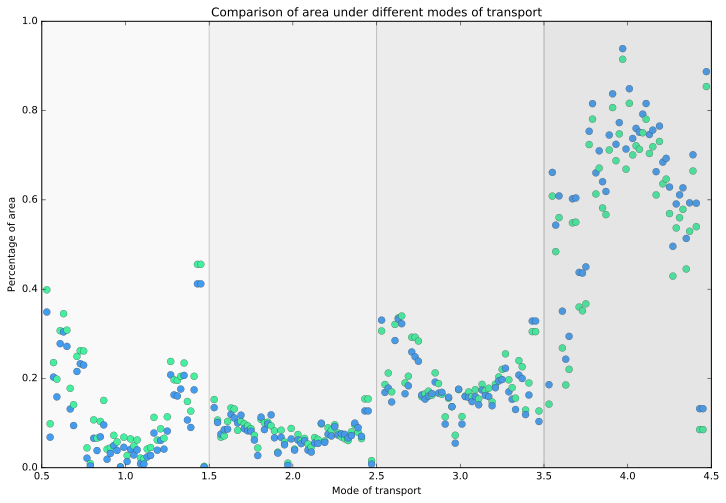

In [89]:
fig = plt.figure()
#fig, ax = plt.subplots()
rcParams['figure.figsize'] = (12,8)

p = 0
year = 2015

#ax.fill_between(x, 0, 1, where=y < -theta, facecolor='red', alpha=0.5, transform=trans)
plt.axvspan(0.5, 1.5, alpha=0.05, color='grey')
plt.axvline(1.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(1.5, 2.5, alpha=0.1, color='grey')
plt.axvline(2.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(2.5, 3.5, alpha=0.15, color='grey')
plt.axvline(3.5, color='grey', linestyle='-',alpha=0.25)
plt.axvspan(3.5, 4.5, alpha=0.2, color='grey')

for month in range(1,13):
    for day in range(1,28,7):

        x = np.load("data/XtransMode-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y = np.load("data/YtransModeSil-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        y1 = np.load("data/YtransModeCalc-"+str(year)+"-"+str(month)+"-"+str(day)+".dat")
        plt.scatter(x-0.5+0.02*p+0.03, y, s=50, facecolors='#42f4a1', edgecolors='k', linewidth='0.2', label='silicilastic sand')
        plt.scatter(x-0.5+0.02*p+0.03, y1, s=50, facecolors='#419df4', edgecolors='k', linewidth='0.2', label='calcareous sand')
        #plt.legend(loc='upper right')
        p += 1

plt.xlim(0.5,4.5)
plt.ylim(0.,1.)
plt.title("Comparison of area under different modes of transport")
plt.xlabel("Mode of transport")
plt.ylabel("Percentage of area")

plt.show()
fig.savefig('figs/comprouse2015.pdf')